# Cell Analysis Utilities for CSV Data

This module provides functions for loading, analyzing, and visualizing 
cell measurement data from CSV files generated by the fluorescence 
microscopy processing pipeline.

In [23]:
# Necessary imports for the module
import os
import glob
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Union, Optional, Tuple
from scipy import stats
from statsmodels.stats.multitest import multipletests
from skimage.filters import threshold_otsu
from sklearn.mixture import GaussianMixture


import AutoImgUtils as autils

In [24]:
%matplotlib widget

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Function Definitions for Analysis

### Data I/O Functions

In [25]:
def load_csv_data(file_path: Union[str, Path]) -> pd.DataFrame:
    """
    Load cell measurement data from a CSV file.

    Parameters:
    - file_path: Path to the CSV file.

    Returns:
    - DataFrame containing the cell measurement data.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} does not exist.")
    
    df = pd.read_csv(file_path)
    
    # Ensure that the 'cell_id' column is present
    if 'cell_id' not in df.columns:
        raise ValueError("CSV file must contain a 'cell_id' column.")
    
    return df



In [26]:
def remove_outliers(df: pd.DataFrame, column: str, method: str = 'iqr', 
                   factor: float = 1.5) -> pd.DataFrame:
    """
    Clip outliers from a DataFrame based on a specific column.
    
    Parameters:
    - df: DataFrame containing the cell measurement data
    - column: Name of the column to use for outlier detection
    - method: Method for outlier detection ('iqr', 'zscore' or 'mad')
    - factor: Factor for outlier detection (1.5 for IQR, 3.0 for z-score typically and 3.5 for MAD)
    
    Returns:
    - DataFrame with outliers clipped to bounds
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame. Available columns: {list(df.columns)}")
    
    df_clean = df.copy()
    
    if method == 'iqr':
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
    elif method == 'zscore':
        mean = df_clean[column].mean()
        std = df_clean[column].std()
        lower_bound = mean - factor * std
        upper_bound = mean + factor * std
        
    elif method == 'mad':
        median = df_clean[column].median()
        mad = np.median(np.abs(df_clean[column] - median))
        lower_bound = median - factor * mad
        upper_bound = median + factor * mad
        
    else:
        raise ValueError("Method must be either 'iqr', 'zscore', or 'mad'")
    
    # Count outliers before clipping
    outliers_count = ((df_clean[column] < lower_bound) | (df_clean[column] > upper_bound)).sum()
    
    # Clip outliers to bounds
    df_clean[column] = df_clean[column].clip(lower=lower_bound, upper=upper_bound)
    
    print(f"Clipped {outliers_count} outliers ({(outliers_count/len(df)*100):.1f}%) in column '{column}'")
    print(f"Dataset rows: {len(df)}")
    print(f"Lower bound: {lower_bound:.3f}, Upper bound: {upper_bound:.3f}")
    
    return df_clean

In [27]:
def load_and_process_multiple_csvs(file_paths: List[Union[str, Path]], 
                                 outlier_column: str,
                                 method: str = 'mad',
                                 factor: float = 3.0,
                                 global_outlier_removal: bool = False) -> Tuple[pd.DataFrame, pd.DataFrame, Dict]:
    """
    Load multiple CSV files, apply outlier removal, and return combined datasets.
    
    Parameters:
    - file_paths: List of paths to CSV files
    - outlier_column: Column to use for outlier detection
    - method: Outlier detection method ('iqr', 'zscore', 'mad')
    - factor: Factor for outlier detection
    - global_outlier_removal: Whether to apply additional outlier removal on combined data
    
    Returns:
    - original_combined: Combined original data with dataset labels
    - cleaned_combined: Combined cleaned data with dataset labels  
    - processing_stats: Dictionary with processing statistics
    """
    
    original_dfs = []
    cleaned_dfs = []
    processing_stats = {}
    global_cell_id = 0  # Global counter for unique cell IDs
    
    cell_counts = []
    
    # First pass: collect cell counts from all files
    for file_path in file_paths:
        if os.path.exists(file_path):
            df_temp = pd.read_csv(file_path)
            cell_counts.append(len(df_temp))
        else:
            print(f"Warning: File {file_path} does not exist, skipping...")
    
    # Calculate bounds for dataset size filtering
    mean_cells = np.mean(cell_counts)
    std_cells = np.std(cell_counts)
    lower_bound_cells = mean_cells - 3 * std_cells
    upper_bound_cells = mean_cells + 3 * std_cells
    
    print(f"Dataset size filtering: {lower_bound_cells:.0f} - {upper_bound_cells:.0f} cells")
    print(f"Mean dataset size: {mean_cells:.0f} ± {std_cells:.0f} cells")
    
    excluded_datasets = []
    
    for i, file_path in enumerate(file_paths):
        # Load data
        df = load_csv_data(file_path)
        dataset_name = Path(file_path).stem
        
        # Check if dataset size is within bounds
        if len(df) < lower_bound_cells or len(df) > upper_bound_cells:
            excluded_datasets.append({
                'dataset': dataset_name,
                'cell_count': len(df),
                'reason': 'too_small' if len(df) < lower_bound_cells else 'too_large'
            })
            print(f"Excluding dataset '{dataset_name}': {len(df)} cells ({'too small' if len(df) < lower_bound_cells else 'too large'})")
            continue
        
        # Store original cell_id for reference
        df['original_cell_id'] = df['cell_id']
        
        # Create unique cell_id across all datasets
        df['cell_id'] = range(global_cell_id, global_cell_id + len(df))
        global_cell_id += len(df)
        
        # Add dataset identifier
        df['dataset'] = dataset_name
        df['dataset_id'] = i
        
        # Store original
        original_dfs.append(df)
        
        # Remove outliers within dataset
        df_clean = remove_outliers(df, outlier_column, method, factor)
        
        # Ensure dataset info is preserved after outlier removal
        df_clean['dataset'] = dataset_name
        df_clean['dataset_id'] = i
        
        cleaned_dfs.append(df_clean)
        
        # Store stats
        processing_stats[dataset_name] = {
            'original_count': len(df),
            'cleaned_count': len(df_clean),
            'outliers_removed': len(df) - len(df_clean),
            'outlier_percentage': ((len(df) - len(df_clean))/len(df)*100)
        }
    
    # Print summary of excluded datasets
    if excluded_datasets:
        print(f"\nExcluded {len(excluded_datasets)} dataset(s) due to extreme cell counts:")
        for excluded in excluded_datasets:
            print(f"  - {excluded['dataset']}: {excluded['cell_count']} cells ({excluded['reason']})")
    else:
        print(f"\nNo datasets excluded based on cell count filtering")
    
    # Combine datasets
    original_combined = pd.concat(original_dfs, ignore_index=True)
    cleaned_combined = pd.concat(cleaned_dfs, ignore_index=True)
    
    # Optional global outlier removal
    if global_outlier_removal:
        print("\nApplying global outlier removal...")
        cleaned_combined = remove_outliers(cleaned_combined, outlier_column, method, factor)
    
    return original_combined, cleaned_combined, processing_stats

def compare_datasets_statistics(df: pd.DataFrame, 
                              column: str, 
                              group_by: str = 'dataset') -> pd.DataFrame:
    """
    Calculate comparative statistics across datasets.
    
    Parameters:
    - df: Combined DataFrame with dataset labels
    - column: Column to analyze
    - group_by: Column to group by (default: 'dataset')
    
    Returns:
    - DataFrame with comparative statistics
    """
    stats = df.groupby(group_by)[column].agg([
        'count', 'mean', 'median', 'std', 'min', 'max',
        lambda x: x.quantile(0.25),  # Q1
        lambda x: x.quantile(0.75),  # Q3
    ]).round(3)
    
    stats.columns = ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max', 'Q1', 'Q3']
    stats['IQR'] = stats['Q3'] - stats['Q1']
    
    return stats

In [28]:
def load_experiments_from_folder_structure(
    main_folder_path: Union[str, Path],
    outlier_column: str = 'channel_2_ctcf',
    method: str = 'mad',
    factor: float = 3.0,
    global_outlier_removal: bool = False,
    file_pattern: str = '*.csv'
) -> Tuple[Dict[str, Tuple[pd.DataFrame, pd.DataFrame, Dict]], Dict[str, List[str]]]:
    """
    Load experimental data from a folder structure where each subfolder represents
    an experimental condition and contains CSV files with cell data.
    
    Parameters:
    - main_folder_path: Path to the main folder containing experimental subfolders
    - outlier_column: Column to use for outlier detection
    - method: Outlier detection method ('iqr', 'zscore', 'mad')
    - factor: Factor for outlier detection
    - global_outlier_removal: Whether to apply additional outlier removal on combined data
    - file_pattern: Pattern to match CSV files (default: '*.csv')
    
    Returns:
    - experiment_data: Dictionary with experiment names as keys and 
      (original_df, cleaned_df, processing_stats) tuples as values
    - experiment_file_paths: Dictionary with experiment names as keys and 
      list of file paths as values
    """
    
    main_folder = Path(main_folder_path)
    if not main_folder.exists():
        raise FileNotFoundError(f"Main folder {main_folder_path} does not exist.")
    
    experiment_data = {}
    experiment_file_paths = {}
    
    # Get all subdirectories (experimental conditions)
    experiment_folders = [f for f in main_folder.iterdir() if f.is_dir()]
    
    if not experiment_folders:
        raise ValueError(f"No subfolders found in {main_folder_path}")
    
    print(f"Found {len(experiment_folders)} experimental conditions:")
    for folder in experiment_folders:
        print(f"  - {folder.name}")
    print()
    
    # Process each experimental condition
    for exp_folder in experiment_folders:
        exp_name = exp_folder.name
        
        # Find all CSV files in the experimental folder
        csv_files = list(exp_folder.glob(file_pattern))
        
        if not csv_files:
            print(f"Warning: No CSV files found in {exp_name}, skipping...")
            continue
        
        print(f"Processing experiment '{exp_name}' with {len(csv_files)} CSV files...")
        
        # Store file paths
        experiment_file_paths[exp_name] = [str(f) for f in csv_files]
        
        try:
            # Load and process the CSV files for this experiment
            original_df, cleaned_df, processing_stats = load_and_process_multiple_csvs(
                file_paths=csv_files,
                outlier_column=outlier_column,
                method=method,
                factor=factor,
                global_outlier_removal=global_outlier_removal
            )
            
            # Add experiment label to the DataFrames
            original_df['experiment'] = exp_name
            cleaned_df['experiment'] = exp_name
            
            # Store the results
            experiment_data[exp_name] = (original_df, cleaned_df, processing_stats)
            
            print(f"  ✓ Successfully processed {len(original_df)} cells")
            
        except Exception as e:
            print(f"  ✗ Error processing experiment '{exp_name}': {str(e)}")
            continue
    
    print(f"\nSuccessfully loaded {len(experiment_data)} experiments.")
    return experiment_data, experiment_file_paths


def create_experiment_lists(
    experiment_data: Dict[str, Tuple[pd.DataFrame, pd.DataFrame, Dict]],
    use_cleaned: bool = True
) -> Tuple[List[pd.DataFrame], List[str]]:
    """
    Create lists of DataFrames and labels from experiment data dictionary.
    
    Parameters:
    - experiment_data: Dictionary from load_experiments_from_folder_structure
    - use_cleaned: Whether to use cleaned data (True) or original data (False)
    
    Returns:
    - datasets: List of DataFrames
    - labels: List of experiment names (labels)
    """
    
    datasets = []
    labels = []
    
    for exp_name, (original_df, cleaned_df, stats) in experiment_data.items():
        df = cleaned_df if use_cleaned else original_df
        datasets.append(df)
        labels.append(exp_name)
    
    return datasets, labels


def print_experiment_summary(experiment_data: Dict[str, Tuple[pd.DataFrame, pd.DataFrame, Dict]]):
    """
    Print a summary of loaded experiments.
    
    Parameters:
    - experiment_data: Dictionary from load_experiments_from_folder_structure
    """
    
    print("=" * 60)
    print("EXPERIMENT SUMMARY")
    print("=" * 60)
    
    total_cells_original = 0
    total_cells_cleaned = 0
    
    for exp_name, (original_df, cleaned_df, processing_stats) in experiment_data.items():
        print(f"\nExperiment: {exp_name}")
        print(f"  Original cells: {len(original_df)}")
        print(f"  Cleaned cells:  {len(cleaned_df)}")
        print(f"  Datasets combined: {len(processing_stats)}")
        
        total_cells_original += len(original_df)
        total_cells_cleaned += len(cleaned_df)
        
        # Show individual dataset stats
        for dataset_name, stats in processing_stats.items():
            outlier_pct = stats['outlier_percentage']
            print(f"    {dataset_name}: {stats['cleaned_count']} cells ({outlier_pct:.1f}% outliers removed)")
    
    print(f"\n" + "=" * 60)
    print(f"TOTAL ACROSS ALL EXPERIMENTS:")
    print(f"  Original cells: {total_cells_original}")
    print(f"  Cleaned cells:  {total_cells_cleaned}")
    print(f"  Overall outliers removed: {total_cells_original - total_cells_cleaned} ({((total_cells_original - total_cells_cleaned)/total_cells_original*100):.1f}%)")
    print("=" * 60)

In [29]:
def filter_experiment_data(
    experiment_data: Dict[str, Tuple[pd.DataFrame, pd.DataFrame, Dict]],
    include_filters: Optional[List[str]] = None,
    exclude_filters: Optional[List[str]] = None,
    case_sensitive: bool = False
) -> Dict[str, Tuple[pd.DataFrame, pd.DataFrame, Dict]]:
    """
    Filter already loaded experiment data based on experiment names.
    
    Parameters:
    - experiment_data: Dictionary from load_experiments_from_folder_structure
    - include_filters: List of strings that experiment names must contain (OR logic)
    - exclude_filters: List of strings that experiment names must NOT contain
    - case_sensitive: Whether filtering is case sensitive
    
    Returns:
    - Filtered experiment_data dictionary
    """
    
    filtered_data = {}
    
    for exp_name, data in experiment_data.items():
        name_check = exp_name if case_sensitive else exp_name.lower()
        
        # Apply include filters (OR logic)
        if include_filters:
            include_match = False
            for filter_term in include_filters:
                filter_term = filter_term if case_sensitive else filter_term.lower()
                if filter_term in name_check:
                    include_match = True
                    break
            if not include_match:
                continue
        
        # Apply exclude filters
        if exclude_filters:
            exclude_match = False
            for filter_term in exclude_filters:
                filter_term = filter_term if case_sensitive else filter_term.lower()
                if filter_term in name_check:
                    exclude_match = True
                    break
            if exclude_match:
                continue
        
        filtered_data[exp_name] = data
    
    print(f"Filtered experiments: {len(filtered_data)} out of {len(experiment_data)}")
    for name in filtered_data.keys():
        print(f"  - {name}")
    
    return filtered_data

In [30]:
def filter_high_population(df: pd.DataFrame, column: str = 'channel_2_ctcf', 
                          method: str = 'otsu', threshold: Optional[float] = None) -> pd.DataFrame:
    """
    Filter to keep only the high-expressing population.
    
    Parameters:
    - df: DataFrame with cell data
    - column: Column to filter on
    - method: 'otsu', 'gaussian_mixture', 'percentile', 'manual'
    - threshold: Manual threshold value (used if method='manual')
    
    Returns:
    - Filtered DataFrame with only high-expressing cells
    """
    
    if method == 'manual' and threshold is not None:
        filtered_df = df[df[column] > threshold].copy()
        print(f"Manual threshold {threshold}: kept {len(filtered_df)}/{len(df)} cells ({len(filtered_df)/len(df)*100:.1f}%)")
        
    elif method == 'otsu':
        # Otsu's method for automatic threshold selection
        # Convert to histogram bins for Otsu
        hist, bin_edges = np.histogram(df[column], bins=100)
        threshold_val = threshold_otsu(df[column].values)
        
        filtered_df = df[df[column] > threshold_val].copy()
        print(f"Otsu threshold {threshold_val:.3f}: kept {len(filtered_df)}/{len(df)} cells ({len(filtered_df)/len(df)*100:.1f}%)")
        
    elif method == 'gaussian_mixture':
        
        
        # Fit 2-component Gaussian mixture
        gmm = GaussianMixture(n_components=2, random_state=42)
        data_reshaped = df[column].values.reshape(-1, 1)
        gmm.fit(data_reshaped)
        
        # Find the component with higher mean
        means = gmm.means_.flatten()
        high_component = np.argmax(means)
        
        # Use intersection point as threshold
        if len(means) == 2:
            # Calculate intersection point between two Gaussians
            mu1, mu2 = means[0], means[1]
            sigma1 = np.sqrt(gmm.covariances_[0][0][0])
            sigma2 = np.sqrt(gmm.covariances_[1][0][0])
            
            # Approximate intersection (more complex calculation possible)
            threshold_val = (mu1 + mu2) / 2
        else:
            threshold_val = means[high_component] - 2 * np.sqrt(gmm.covariances_[high_component][0][0])
        
        filtered_df = df[df[column] > threshold_val].copy()
        print(f"Gaussian mixture threshold {threshold_val:.3f}: kept {len(filtered_df)}/{len(df)} cells ({len(filtered_df)/len(df)*100:.1f}%)")
        
    elif method == 'percentile':
        # Use a percentile-based approach
        threshold_val = df[column].quantile(0.5)  # Adjust percentile as needed
        filtered_df = df[df[column] > threshold_val].copy()
        print(f"50th percentile threshold {threshold_val:.3f}: kept {len(filtered_df)}/{len(df)} cells ({len(filtered_df)/len(df)*100:.1f}%)")
        
    else:
        raise ValueError("Method must be 'otsu', 'gaussian_mixture', 'percentile', or 'manual'")
    
    return filtered_df

def filter_experiment_populations(experiment_data, column='channel_2_ctcf', 
                                method='otsu', threshold=None):
    """
    Apply population filtering to all experiments.
    """
    filtered_experiment_data = {}
    
    for exp_name, (original_df, cleaned_df, stats) in experiment_data.items():
        print(f"\nFiltering {exp_name}:")
        
        # Apply filtering to cleaned data
        filtered_df = filter_high_population(cleaned_df, column, method, threshold)
        
        # Update stats
        new_stats = stats.copy()
        new_stats['high_pop_filtering'] = {
            'pre_filter_count': len(cleaned_df),
            'post_filter_count': len(filtered_df),
            'cells_removed': len(cleaned_df) - len(filtered_df),
            'removal_percentage': ((len(cleaned_df) - len(filtered_df))/len(cleaned_df)*100)
        }
        
        filtered_experiment_data[exp_name] = (original_df, filtered_df, new_stats)
    
    return filtered_experiment_data

In [31]:
def calculate_global_threshold(experiment_data, column='channel_2_ctcf', method='otsu'):
    """
    Calculate a single threshold from all experiment data combined.
    """
    # Combine all cleaned data
    all_data = []
    for exp_name, (original_df, cleaned_df, stats) in experiment_data.items():
        all_data.append(cleaned_df[column])
    
    combined_signal = pd.concat(all_data, ignore_index=True)
    
    if method == 'otsu':
        from skimage.filters import threshold_otsu
        global_threshold = threshold_otsu(combined_signal.values)
    elif method == 'gaussian_mixture':
        from sklearn.mixture import GaussianMixture
        gmm = GaussianMixture(n_components=2, random_state=42)
        data_reshaped = combined_signal.values.reshape(-1, 1)
        gmm.fit(data_reshaped)
        means = gmm.means_.flatten()
        global_threshold = (means[0] + means[1]) / 2
    elif method == 'percentile':
        global_threshold = combined_signal.quantile(0.5)  # or whatever percentile
    else:
        raise ValueError("Method must be 'otsu', 'gaussian_mixture', or 'percentile'")
    
    print(f"Global threshold calculated: {global_threshold:.3f}")
    return global_threshold

def apply_global_threshold(experiment_data, threshold, column='channel_2_ctcf'):
    """
    Apply the same threshold to all experiments.
    """
    filtered_experiment_data = {}
    
    for exp_name, (original_df, cleaned_df, stats) in experiment_data.items():
        print(f"Applying global threshold to {exp_name}:")
        
        # Apply same threshold to all
        filtered_df = cleaned_df[cleaned_df[column] > threshold].copy()
        
        print(f"  Kept {len(filtered_df)}/{len(cleaned_df)} cells ({len(filtered_df)/len(cleaned_df)*100:.1f}%)")
        
        # Update stats
        new_stats = stats.copy()
        new_stats['global_threshold_filtering'] = {
            'threshold_value': threshold,
            'pre_filter_count': len(cleaned_df),
            'post_filter_count': len(filtered_df),
            'cells_removed': len(cleaned_df) - len(filtered_df),
            'removal_percentage': ((len(cleaned_df) - len(filtered_df))/len(cleaned_df)*100)
        }
        
        filtered_experiment_data[exp_name] = (original_df, filtered_df, new_stats)
    
    return filtered_experiment_data

### Visualization (Statistics)

In [32]:
def plot_violin(df: pd.DataFrame, column: str, title: Optional[str] = None, 
                figsize: Tuple[int, int] = (8, 6)) -> None:
    """
    Create a violin plot for a specific column in the cell data DataFrame.
    
    Parameters:
    - df: DataFrame containing the cell measurement data
    - column: Name of the column to plot
    - title: Optional title for the plot
    - figsize: Figure size as (width, height)
    
    Returns:
    - None (displays the plot)
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame. Available columns: {list(df.columns)}")
    
    plt.figure(figsize=figsize)
    sns.violinplot(y=df[column])
    
    if title is None:
        title = f"Distribution of {column}"
    
    plt.title(title)
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()

def plot_violin_comparison(datasets: List[pd.DataFrame], column: str, 
                            dataset_labels: Optional[List[str]] = None,
                            hue = None,
                            title: Optional[str] = None, 
                            figsize: Optional[Tuple[int, int]] = None) -> None:
    """
    Create violin plots comparing the same column across multiple datasets.
    
    Parameters:
    - datasets: List of DataFrames containing the cell measurement data
    - column: Name of the column to plot
    - dataset_labels: Optional list of labels for each dataset
    - title: Optional title for the plot
    - figsize: Optional figure size as (width, height). If None, adapts to number of datasets
    
    Returns:
    - None (displays the plot)
    """
    if not datasets:
        raise ValueError("At least one dataset must be provided")
    
    # Check if column exists in all datasets
    for i, df in enumerate(datasets):
        if column not in df.columns:
            raise ValueError(f"Column '{column}' not found in dataset {i}. Available columns: {list(df.columns)}")
    
    # Set default labels if not provided
    if dataset_labels is None:
        dataset_labels = [f"Dataset {i+1}" for i in range(len(datasets))]
    elif len(dataset_labels) != len(datasets):
        raise ValueError("Number of dataset labels must match number of datasets")
    # Prepare data for seaborn
    combined_data = []
    for i, (df, label) in enumerate(zip(datasets, dataset_labels)):
        temp_df = pd.DataFrame({
            column: df[column],
            'Dataset': label
        })
        combined_data.append(temp_df)
    
    plot_data = pd.concat(combined_data, ignore_index=True)

    # Optional data normalization
    if hue is not None and hue in dataset.columns:
        # Group by hue and normalize within each group
        normalized_data = []
        for group_name, group_df in dataset.groupby(hue):
            group_normalized = group_df.copy()
            # Min-max normalization within group
            min_val = group_df[column].min()
            max_val = group_df[column].max()
            if max_val != min_val:
                group_normalized[column] = (group_df[column] - min_val) / (max_val - min_val)
            else:
                group_normalized[column] = 0
            normalized_data.append(group_normalized)
        dataset = pd.concat(normalized_data, ignore_index=True)
    if hue is not None and hue in plot_data.columns:
        # Group by hue and normalize within each group
        normalized_data = []
        for group_name, group_df in plot_data.groupby(hue):
            group_normalized = group_df.copy()
            # Min-max normalization within group
            min_val = group_df[column].min()
            max_val = group_df[column].max()
            if max_val != min_val:
                group_normalized[column] = (group_df[column] - min_val) / (max_val - min_val)
            else:
                group_normalized[column] = 0
            normalized_data.append(group_normalized)
        plot_data = pd.concat(normalized_data, ignore_index=True)
    
    # Adaptive figure size
    if figsize is None:
        width = max(8, len(datasets) * 2)
        figsize = (width, 6)
    
    plt.figure(figsize=figsize)
    sns.violinplot(data=plot_data, x='Dataset', y=column , color= 'seagreen', log_scale=False)
    
    if title is None:
        title = f"Comparison of {column} across datasets"
    
    plt.title(title)
    plt.ylabel(column)
    plt.xticks(rotation=45 if len(dataset_labels) > 3 else 0)
    plt.tight_layout()
    plt.show()

def plot_scatter(df: pd.DataFrame, x_column: str, y_column: str, 
                    title: Optional[str] = None, 
                    figsize: Tuple[int, int] = (8, 6),
                    alpha: float = 0.6) -> None:
    """
    Create a scatter plot of one column against another.
    
    Parameters:
    - df: DataFrame containing the cell measurement data
    - x_column: Name of the column for x-axis
    - y_column: Name of the column for y-axis
    - title: Optional title for the plot
    - figsize: Figure size as (width, height)
    - alpha: Transparency of points (0-1)
    
    Returns:
    - None (displays the plot)
    """
    if x_column not in df.columns:
        raise ValueError(f"Column '{x_column}' not found in DataFrame. Available columns: {list(df.columns)}")
    if y_column not in df.columns:
        raise ValueError(f"Column '{y_column}' not found in DataFrame. Available columns: {list(df.columns)}")
    
    plt.figure(figsize=figsize)
    plt.scatter(df[x_column], df[y_column], alpha=alpha)
    
    if title is None:
        title = f"{y_column} vs {x_column}"
    
    plt.title(title)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.tight_layout()
    plt.show()


def plot_ridgeline_comparison(
    datasets: List[pd.DataFrame],
    column: str,
    dataset_labels: Optional[List[str]] = None,
    title: Optional[str] = None,
    figsize: Optional[Tuple[int, int]] = None,
    bw_adjust: float = 1.0,
    fill: bool = True,
    palette: Union[str, List[str]] = "viridis",
    alpha: float = 0.7,
    line_width: float = 1.0,
    scale: float = 0.9,
    sample_max: Optional[int] = 8000,
    normalize: bool = False,
    normalization_method: str = "minmax",
    # New statistical parameters
    statistical_test: Optional[str] = None,
    reference_dataset: Optional[int] = None,
    significance_level: float = 0.05,
    correction_method: str = "bonferroni"
) -> Optional[pd.DataFrame]:
    """
    Ridgeline (joy) plot comparing distributions of one column across datasets.

    Parameters:
    - datasets: list of DataFrames
    - column: column to plot
    - dataset_labels: custom labels (must match length of datasets)
    - title: plot title
    - figsize: figure size; adaptive if None
    - bw_adjust: bandwidth adjustment passed to seaborn.kdeplot
    - fill: whether to fill the density
    - palette: seaborn palette name or list of colors
    - alpha: transparency for filled areas
    - line_width: width of KDE outline
    - scale: vertical scale of each ridge (0–1.2 typical)
    - sample_max: subsample each dataset to this many rows for speed (None disables)
    - normalize: whether to normalize the data before plotting
    - normalization_method: "minmax" or "zscore" normalization method
    - statistical_test: test to perform ("mannwhitney", "ttest", "ks", "kruskal", None)
    - reference_dataset: index of reference dataset for pairwise tests (0-based)
    - significance_level: alpha level for significance (default 0.05)
    - correction_method: multiple testing correction ("bonferroni", "holm", "benjamini", None)

    Returns:
    - DataFrame with statistical test results if statistical_test is specified, None otherwise
    """
    
    if not datasets:
        raise ValueError("At least one dataset must be provided")

    # Validate column presence
    for i, df in enumerate(datasets):
        if column not in df.columns:
            raise ValueError(f"Column '{column}' not found in dataset {i}. Available: {list(df.columns)}")

    # Labels
    if dataset_labels is None:
        dataset_labels = [f"Dataset {i+1}" for i in range(len(datasets))]
    if len(dataset_labels) != len(datasets):
        raise ValueError("dataset_labels length must match datasets length")

    # Figure size - increased height to prevent cutoff
    if figsize is None:
        height = max(4, 1.0 * len(datasets) + 2)
        figsize = (10, height)

    try:
        np  # type: ignore
    except NameError:
        import numpy as np  # noqa: F401

    # Colors
    if isinstance(palette, str):
        colors = sns.color_palette(palette, len(datasets))
    else:
        if len(palette) < len(datasets):
            raise ValueError("Provided palette has fewer colors than datasets")
        colors = palette[:len(datasets)]

    # Prepare data with optional global normalization
    processed_datasets = []
    raw_datasets = []  # Keep raw data for statistics
    
    # First, collect all data for global normalization parameters
    if normalize:
        all_data = []
        for df in datasets:
            data = df[column].dropna()
            if sample_max is not None and len(data) > sample_max:
                data = data.sample(sample_max, random_state=0)
            all_data.append(data)
        
        # Calculate global normalization parameters
        combined_data = pd.concat(all_data, ignore_index=True)
        if normalization_method == "minmax":
            global_min = combined_data.min()
            global_max = combined_data.max()
        elif normalization_method == "zscore":
            global_mean = combined_data.mean()
            global_std = combined_data.std()
        else:
            raise ValueError("normalization_method must be 'minmax' or 'zscore'")
    
    # Process each dataset with global normalization parameters
    for df in datasets:
        data = df[column].dropna()
        if sample_max is not None and len(data) > sample_max:
            data = data.sample(sample_max, random_state=0)
        
        # Store raw data for statistical tests
        raw_datasets.append(data.copy())
        
        if normalize:
            if normalization_method == "minmax":
                if global_max != global_min:
                    data = (data - global_min) / (global_max - global_min)
                else:
                    data = pd.Series([0] * len(data))
            elif normalization_method == "zscore":
                if global_std != 0:
                    data = (data - global_mean) / global_std
                else:
                    data = pd.Series([0] * len(data))
        
        processed_datasets.append(data)

    # Statistical testing
    stats_results = None
    if statistical_test is not None:
        stats_results = _perform_statistical_tests(
            raw_datasets, 
            dataset_labels, 
            statistical_test,
            reference_dataset,
            significance_level,
            correction_method
        )

    # Collect global min/max for consistent x-limits
    global_min = min(data.min() for data in processed_datasets)
    global_max = max(data.max() for data in processed_datasets)

    fig, ax = plt.subplots(figsize=figsize)

    # Plot from bottom to top so last appears on top visually
    for idx, (data, label, color) in enumerate(zip(processed_datasets, dataset_labels, colors)):
        # Track existing artists to isolate new ones
        prev_lines = len(ax.lines)
        prev_collections = len(ax.collections)

        sns.kdeplot(
            data=data,
            bw_adjust=bw_adjust,
            fill=fill,
            ax=ax,
            color=color,
            linewidth=line_width,
            clip=(global_min, global_max),
        )

        # Adjust newly added line(s)
        new_lines = ax.lines[prev_lines:]
        for line in new_lines:
            x = line.get_xdata()
            y = line.get_ydata()
            peak = y.max() if y.max() != 0 else 1.0
            y_scaled = (y / peak) * scale + idx
            line.set_ydata(y_scaled)
            line.set_alpha(1.0)

        # Adjust fills (PolyCollections) if any
        if fill:
            new_colls = ax.collections[prev_collections:]
            for coll in new_colls:
                for path in coll.get_paths():
                    verts = path.vertices
                    y = verts[:, 1]
                    peak = y.max() if y.max() != 0 else 1.0
                    y_scaled = (y / peak) * scale + idx
                    verts[:, 1] = y_scaled
                coll.set_alpha(alpha)
                coll.set_edgecolor("none")

    ax.set_yticks(range(len(datasets)))
    ax.set_yticklabels(dataset_labels)
    ax.set_xlim(global_min, global_max)
    ax.set_ylim(0, len(datasets))  # Add buffer space
    
    # Update x-axis label based on normalization
    xlabel = column
    if normalize:
        if normalization_method == "minmax":
            xlabel += " (Min-Max Normalized)"
        elif normalization_method == "zscore":
            xlabel += " (Z-Score Normalized)"
    ax.set_xlabel(xlabel)
    ax.set_ylabel("")
    
    if title is None:
        title = f"Ridgeline comparison of {column}"
        if normalize:
            title += f" ({normalization_method} normalized)"
    ax.set_title(title)

    # Aesthetic cleanup
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.grid(axis="x", alpha=0.2)
    ax.tick_params(axis="y", length=0)

    # Add significance annotations if statistical tests were performed
    if stats_results is not None and not stats_results.empty:
        _add_significance_annotations(ax, stats_results, dataset_labels, len(datasets))

    plt.tight_layout()
    plt.show()

    # Print statistical results
    if stats_results is not None:
        print("\nStatistical Test Results:")
        print("=" * 50)
        display(stats_results)

    return stats_results


def _perform_statistical_tests(
    datasets: List[pd.Series],
    labels: List[str],
    test_type: str,
    reference_idx: Optional[int],
    alpha: float,
    correction: str
) -> pd.DataFrame:
    """
    Perform statistical tests between datasets.
    """
    
    results = []
    
    if test_type == "kruskal" and len(datasets) > 2:
        # Kruskal-Wallis test for all groups
        statistic, p_value = stats.kruskal(*datasets)
        results.append({
            'Test': 'Kruskal-Wallis',
            'Group1': 'All',
            'Group2': 'All',
            'Statistic': statistic,
            'P-value': p_value,
            'Significant': p_value < alpha
        })
    
    # Pairwise tests
    if reference_idx is not None:
        # Compare all datasets to reference
        ref_data = datasets[reference_idx]
        ref_label = labels[reference_idx]
        
        for i, (data, label) in enumerate(zip(datasets, labels)):
            if i == reference_idx:
                continue
                
            stat, p_val = _get_test_statistic(ref_data, data, test_type)
            results.append({
                'Test': test_type.title(),
                'Group1': ref_label,
                'Group2': label,
                'Statistic': stat,
                'P-value': p_val,
                'Significant': p_val < alpha
            })
    else:
        # All pairwise comparisons
        for i in range(len(datasets)):
            for j in range(i + 1, len(datasets)):
                stat, p_val = _get_test_statistic(datasets[i], datasets[j], test_type)
                results.append({
                    'Test': test_type.title(),
                    'Group1': labels[i],
                    'Group2': labels[j],
                    'Statistic': stat,
                    'P-value': p_val,
                    'Significant': p_val < alpha
                })
    
    df = pd.DataFrame(results)
    
    # Apply multiple testing correction
    if correction and correction.lower() != 'none' and len(df) > 1:
        p_values = df['P-value'].values
        if correction.lower() == 'bonferroni':
            corrected = multipletests(p_values, method='bonferroni')
        elif correction.lower() == 'holm':
            corrected = multipletests(p_values, method='holm')
        elif correction.lower() == 'benjamini':
            corrected = multipletests(p_values, method='fdr_bh')
        else:
            raise ValueError("correction_method must be 'bonferroni', 'holm', 'benjamini', or None")
        
        df['P-value (corrected)'] = corrected[1]
        df['Significant (corrected)'] = corrected[0]
    
    return df


def _get_test_statistic(data1: pd.Series, data2: pd.Series, test_type: str) -> Tuple[float, float]:
    """
    Get test statistic and p-value for specified test.
    """
    
    if test_type.lower() == 'mannwhitney':
        return stats.mannwhitneyu(data1, data2, alternative='two-sided')
    elif test_type.lower() == 'ttest':
        return stats.ttest_ind(data1, data2)
    elif test_type.lower() == 'ks':
        return stats.ks_2samp(data1, data2)
    else:
        raise ValueError("test_type must be 'mannwhitney', 'ttest', or 'ks'")


def _add_significance_annotations(ax, stats_df: pd.DataFrame, labels: List[str], n_datasets: int):
    """
    Add significance annotations to the plot.
    """
    # Simple approach: add asterisks for significant comparisons
    xlim = ax.get_xlim()
    x_pos = xlim[1] * 1.02  # Position to the right of the plot
    
    for idx, row in stats_df.iterrows():
        if 'Significant (corrected)' in row:
            is_significant = row['Significant (corrected)']
            p_val = row['P-value (corrected)']
        else:
            is_significant = row['Significant']
            p_val = row['P-value']
        
        if is_significant:
            # Find y positions for the groups
            try:
                y1 = labels.index(row['Group1'])
                y2 = labels.index(row['Group2'])
                y_mid = (y1 + y2) / 2
                
                # Add significance marker
                if p_val < 0.001:
                    marker = "***"
                elif p_val < 0.01:
                    marker = "**"
                elif p_val < 0.05:
                    marker = "*"
                else:
                    marker = "ns"
                
                ax.text(x_pos, y_mid, marker, fontsize=8, ha='left', va='center')
            except ValueError:
                # Skip if labels not found (e.g., for overall tests)
                continue

## Cell-Analysis

In [84]:
main_experiment_folder = autils.select_folder()

In [85]:
experiment_data, file_paths = load_experiments_from_folder_structure(
    main_folder_path=main_experiment_folder,
    outlier_column='channel_2_ctcf',
    factor=3.0,  # using your std_factor
    method='mad'
)

Found 13 experimental conditions:
  - 0_OnlyEXP
  - Cal_Dox48_Dark
  - Cal_Dox48_Light
  - Cal_DoxCont_Dark
  - Cal_DoxCont_Light
  - Cal_NoDox_Dark
  - Cal_NoDox_Light
  - scFl_Dox48_Dark
  - scFl_Dox48_Light
  - scFl_DoxCont_Dark
  - scFl_DoxCont_Light
  - scFl_NoDox_Dark
  - scFl_NoDox_Light

Processing experiment '0_OnlyEXP' with 36 CSV files...
Dataset size filtering: 696 - 8432 cells
Mean dataset size: 4564 ± 1289 cells
Clipped 18 outliers (0.6%) in column 'channel_2_ctcf'
Dataset rows: 3249
Lower bound: -680182.667, Upper bound: 2777889.164
Clipped 18 outliers (0.4%) in column 'channel_2_ctcf'
Dataset rows: 5101
Lower bound: -958217.677, Upper bound: 2745528.922
Clipped 118 outliers (2.2%) in column 'channel_2_ctcf'
Dataset rows: 5433
Lower bound: -113084.858, Upper bound: 2076520.311
Clipped 57 outliers (1.0%) in column 'channel_2_ctcf'
Dataset rows: 5923
Lower bound: -563639.761, Upper bound: 2495391.413
Clipped 83 outliers (1.3%) in column 'channel_2_ctcf'
Dataset rows: 6611


In [86]:
# Print summary of what was loaded
print_experiment_summary(experiment_data)

# Create lists for plotting (similar to your current approach)
datasets, labels = create_experiment_lists(experiment_data, use_cleaned=True)

EXPERIMENT SUMMARY

Experiment: 0_OnlyEXP
  Original cells: 164311
  Cleaned cells:  164311
  Datasets combined: 36
    EXP10_2_1_2_3_4_only_GFP_DoxCont_Light-OME TIFF-Export-04_s1.ome_cells: 3249 cells (0.0% outliers removed)
    EXP10_2_1_2_3_4_only_GFP_DoxCont_Light-OME TIFF-Export-04_s2.ome_cells: 5101 cells (0.0% outliers removed)
    EXP10_2_1_2_3_4_only_GFP_DoxCont_Light-OME TIFF-Export-04_s3.ome_cells: 5433 cells (0.0% outliers removed)
    EXP10_2_1_2_3_4_only_GFP_DoxCont_Light-OME TIFF-Export-04_s4.ome_cells: 5923 cells (0.0% outliers removed)
    EXP10_2_1_2_3_4_only_GFP_DoxCont_Light-OME TIFF-Export-04_s5.ome_cells: 6611 cells (0.0% outliers removed)
    EXP10_2_1_2_3_4_only_GFP_DoxCont_Light-OME TIFF-Export-04_s6.ome_cells: 6916 cells (0.0% outliers removed)
    EXP10_2_3_2_4_5_only_scFL_No_Dox_Light-OME TIFF-Export-14_s1.ome_cells: 2890 cells (0.0% outliers removed)
    EXP10_2_3_2_4_5_only_scFL_No_Dox_Light-OME TIFF-Export-14_s2.ome_cells: 3304 cells (0.0% outliers remov

In [87]:
# global_threshold = calculate_global_threshold(experiment_data, method='otsu')
# print(f"Global threshold determined: {global_threshold:.3f}")

# globally_filtered_data = apply_global_threshold(experiment_data, global_threshold)

# filtered_datasets, filtered_labels = create_experiment_lists(globally_filtered_data, use_cleaned=True)

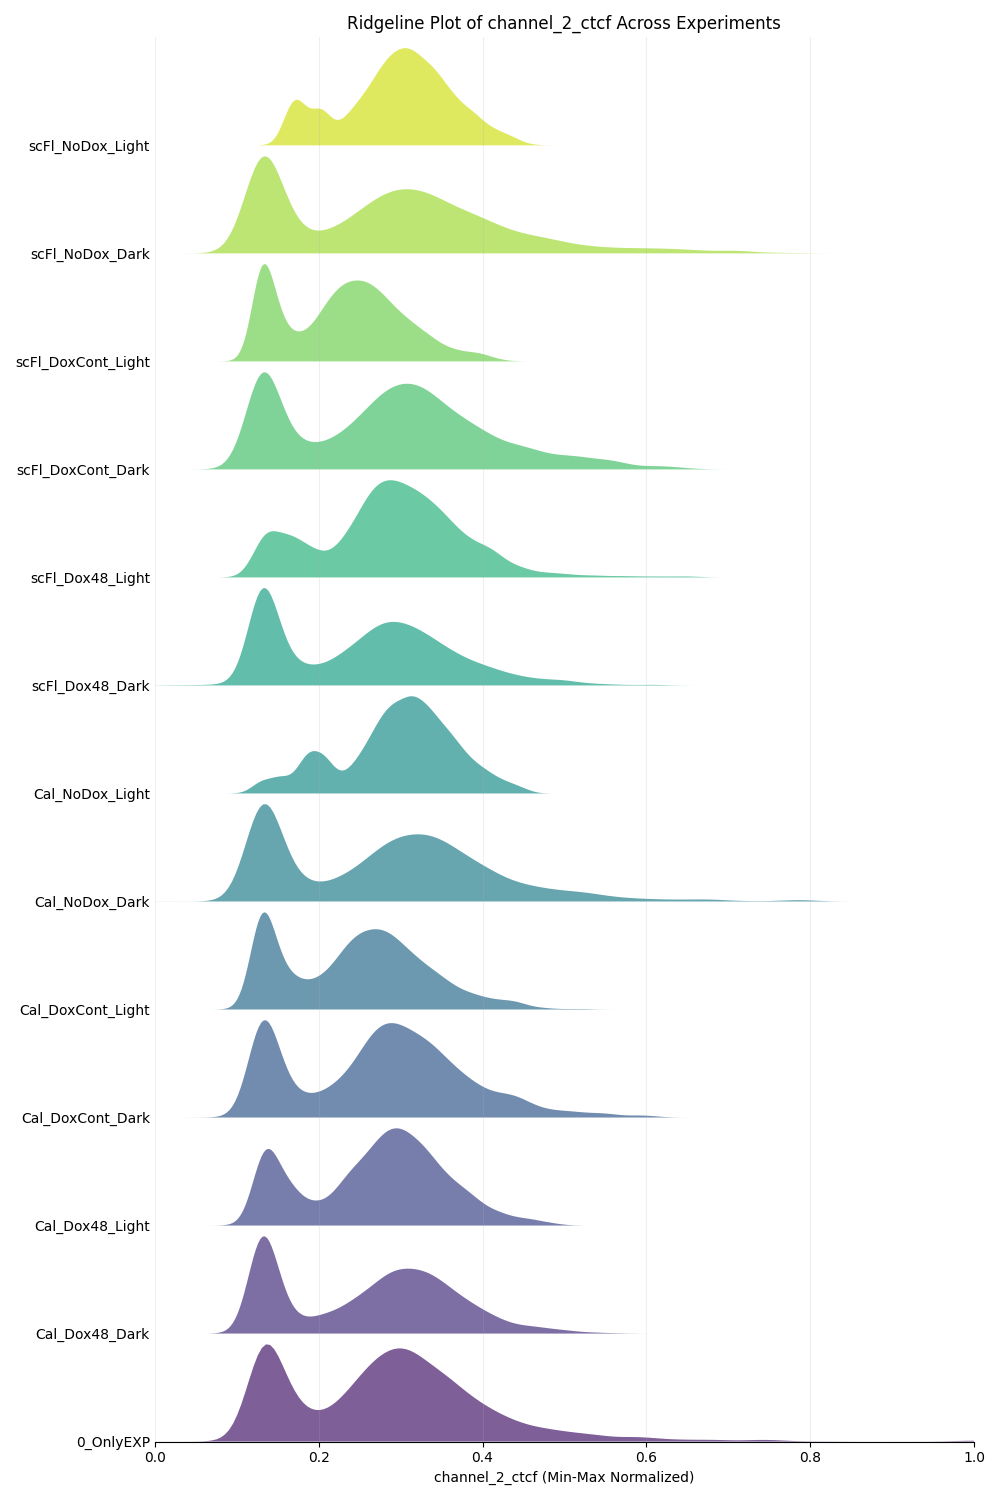

In [88]:
plt.close('all')

plot_ridgeline_comparison(
    datasets,
    column='channel_2_ctcf',
    dataset_labels=labels,
    title='Ridgeline Plot of channel_2_ctcf Across Experiments',
    normalize=True,
    normalization_method='minmax',
    statistical_test=None, 
    reference_dataset=0,  # Compare all to the first dataset
)

In [89]:
def calculate_signal_metrics(experiment_data, column='channel_2_ctcf'):
    """
    Calculate comprehensive signal intensity metrics for system comparison.
    """
    metrics = {}
    
    for exp_name, (original_df, cleaned_df, stats) in experiment_data.items():
        df = cleaned_df
        signal = df[column]
        
        metrics[exp_name] = {
            'mean_signal': signal.mean(),
            'median_signal': signal.median(),
            'std_signal': signal.std(),
            'signal_cv': signal.std() / signal.mean(),  # Coefficient of variation
            'dynamic_range': signal.max() - signal.min(),
            'signal_to_noise': signal.mean() / signal.std(),
            'percentile_90': signal.quantile(0.9),
            'percentile_10': signal.quantile(0.1),
            'cell_count': len(df)
        }
    
    return pd.DataFrame(metrics).T

signal_metrics_df = calculate_signal_metrics(experiment_data, column='channel_2_ctcf')
print("\nSignal Intensity Metrics:")
display(signal_metrics_df)


Signal Intensity Metrics:


,mean_signal,median_signal,std_signal,signal_cv,dynamic_range,signal_to_noise,percentile_90,percentile_10,cell_count
0_OnlyEXP,1.209433e+06,1.218663e+06,9.079507e+05,0.750724,7.588801e+06,1.332047,2.274970e+06,72163.268713,164311.0
Cal_Dox48_Dark,1.044728e+06,1.172184e+06,7.546971e+05,0.722386,4.109940e+06,1.384301,1.968193e+06,51577.873134,102240.0
Cal_Dox48_Light,1.105227e+06,1.193336e+06,6.374158e+05,0.576729,3.134821e+06,1.733918,1.887240e+06,129017.261515,86836.0
Cal_DoxCont_Dark,1.165405e+06,1.221422e+06,7.728987e+05,0.663202,4.227150e+06,1.507837,2.147580e+06,72104.659299,64088.0
Cal_DoxCont_Light,9.263107e+05,9.730981e+05,6.388226e+05,0.689642,3.513003e+06,1.450028,1.747830e+06,60584.193630,93862.0
Cal_NoDox_Dark,1.202608e+06,1.263618e+06,9.553089e+05,0.794364,5.960157e+06,1.258868,2.369295e+06,52887.746913,72500.0
Cal_NoDox_Light,1.308426e+06,1.368746e+06,5.229534e+05,0.399681,2.500344e+06,2.501994,1.940144e+06,508740.609456,46068.0
scFl_Dox48_Dark,1.007655e+06,1.078079e+06,7.760989e+05,0.770203,4.571887e+06,1.298359,2.000854e+06,48912.972058,99421.0
scFl_Dox48_Light,1.247914e+06,1.272762e+06,6.550627e+05,0.524926,4.157694e+06,1.905030,2.043730e+06,302530.155858,60621.0
scFl_DoxCont_Dark,1.242294e+06,1.279790e+06,8.883969e+05,0.715126,4.696062e+06,1.398354,2.410500e+06,62511.951542,62626.0


In [ ]:
scfl_data = filter_experiment_data(experiment_data, include_filters=['scFL'])
cal_data = filter_experiment_data(experiment_data, include_filters=['Cal'])

scfl_datasets, scfl_labels = create_experiment_lists(scfl_data, use_cleaned=True)
cal_datasets, cal_labels = create_experiment_lists(cal_data, use_cleaned=True)

In [ ]:
plot_violin_comparison(
    scfl_datasets,
    column='channel_2_ctcf',
    dataset_labels=scfl_labels,
    title='scFL CTCF eYFP Signal Comparison',
)

In [ ]:
plot_violin_comparison(
    cal_datasets, 
    column='channel_2_ctcf',
    dataset_labels=cal_labels,
    title='Cal CTCF eYFP Signal Comparison',
)

In [ ]:
plot_ridgeline_comparison(
    scfl_datasets,
    column='channel_2_ctcf',
    dataset_labels=scfl_labels,
    title='Ridgeline: scFL Channel 2 CTCF across all experiments',
    figsize=(14, 10),
    normalize=False,
    normalization_method='minmax',
    statistical_test='ks'
)

In [ ]:
plot_ridgeline_comparison(
    cal_datasets,
    column='channel_2_ctcf',
    dataset_labels=cal_labels,
    title='Ridgeline: Cal Channel 2 CTCF across all experiments',
    figsize=(14, 10),
    normalize=False,
    normalization_method='minmax',
    statistical_test='ks'
)

In [ ]:
plot_violin_comparison(
    datasets,
    column='channel_2_ctcf',
    dataset_labels=labels,
    title='Comparison of Channel 2 CTCF across all experiments'
)

In [ ]:
plot_ridgeline_comparison(
    datasets,
    column='channel_2_ctcf',
    dataset_labels=labels,
    title='Ridgeline: Channel 2 CTCF across all experiments',
    figsize=(14, 10),
    normalize=True,
    normalization_method='minmax',
    statistical_test='ks'
)

In [ ]:
cell_data_no_dox_dark_path = autils.select_files()
cell_data_no_dox_light_path = autils.select_files()
cell_data_48_dox_dark_path = autils.select_files()
cell_data_48_dox_light_path = autils.select_files()
cell_data_cont_dox_dark_path = autils.select_files()
cell_data_cont_dox_light_path = autils.select_files()

In [ ]:
std_factor = 4.0

cell_data_no_dox_dark =load_and_process_multiple_csvs(cell_data_no_dox_dark_path, outlier_column='channel_2_ctcf', factor = std_factor)
cell_data_no_dox_light = load_and_process_multiple_csvs(cell_data_no_dox_light_path, outlier_column='channel_2_ctcf', factor = std_factor)
cell_data_48_dox_dark = load_and_process_multiple_csvs(cell_data_48_dox_dark_path, outlier_column='channel_2_ctcf', factor = std_factor)
cell_data_48_dox_light = load_and_process_multiple_csvs(cell_data_48_dox_light_path, outlier_column='channel_2_ctcf', factor = std_factor)
cell_data_cont_dox_dark = load_and_process_multiple_csvs(cell_data_cont_dox_dark_path, outlier_column='channel_2_ctcf', factor = std_factor)
cell_data_cont_dox_light = load_and_process_multiple_csvs(cell_data_cont_dox_light_path, outlier_column='channel_2_ctcf', factor = std_factor)

In [ ]:
cell_data_list_dox_cal= [
    cell_data_no_dox_dark[1],
    cell_data_no_dox_light[1],
    cell_data_48_dox_dark[1],
    cell_data_48_dox_light[1],
    cell_data_cont_dox_dark[1],
    cell_data_cont_dox_light[1]
]

for i, dataset in enumerate(cell_data_list_dox_cal):
    dataset['Type'] = 'Cal'

In [ ]:
plot_violin_comparison(
    cell_data_list_dox_cal,
    column='channel_2_ctcf',
    dataset_labels=[
        'No Dox Dark', 
        'No Dox Light', 
        '48h Dox Dark', 
        '48h Dox Light', 
        'Continuous Dox Dark', 
        'Continuous Dox Light'
    ],
    title='Comparison of Channel 2 mean across datasets scFlare',
    # figsize=(12, 6)
)

In [ ]:
plt.close('all')

plot_ridgeline_comparison(
    cell_data_list_dox_cal,
    column='channel_2_ctcf',
    dataset_labels=[
        'No Dox Dark', 
        'No Dox Light', 
        '48h Dox Dark', 
        '48h Dox Light', 
        'Continuous Dox Dark', 
        'Continuous Dox Light'
    ],
    title='Ridgeline: Channel 2 CTCF across scFlare conditions',
    figsize=(14, 10),
    normalize=True,
    normalization_method='minmax',
    statistical_test='ks',
    reference_dataset=0
)

In [ ]:
cell_data_dark_1d = load_and_process_multiple_csvs(cell_data_dark_1d_paths, 
                                                  outlier_column='channel_2_ctcf')
cell_data_dark_2d = load_and_process_multiple_csvs(cell_data_dark_2d_paths,
                                                  outlier_column='channel_2_ctcf')
# cell_data_dark_3d = load_and_process_multiple_csvs(cell_data_dark_3d_paths,
#                                                   outlier_column='channel_2_ctcf')
cell_data_dark_4d = load_and_process_multiple_csvs(cell_data_dark_4d_paths,
                                                    outlier_column='channel_2_ctcf')
cell_data_dark_5d = load_and_process_multiple_csvs(cell_data_dark_5d_paths,
                                                    outlier_column='channel_2_ctcf')
cell_data_dark_6d = load_and_process_multiple_csvs(cell_data_dark_6d_paths,
                                                    outlier_column='channel_2_ctcf')
cell_data_dark_7d = load_and_process_multiple_csvs(cell_data_dark_7d_paths,
                                                    outlier_column='channel_2_ctcf')
cell_data_dark_8d = load_and_process_multiple_csvs(cell_data_dark_8d_paths,
                                                    outlier_column='channel_2_ctcf')

In [ ]:
cell_data_dark_1d[1].head()

## Compare Cal and Flare

In [ ]:
cal_data_path_48 = autils.select_files()
scF_data_path_48 = autils.select_files()
cal_data_path_cont = autils.select_files()
scF_data_path_cont = autils.select_files()

In [ ]:
cal_data_48 = load_and_process_multiple_csvs(cal_data_path_48, outlier_column='channel_2_ctcf', factor = std_factor)
scF_data_48 = load_and_process_multiple_csvs(scF_data_path_48, outlier_column='channel_2_ctcf', factor = std_factor)
cal_data_cont = load_and_process_multiple_csvs(cal_data_path_cont, outlier_column='channel_2_ctcf', factor = std_factor)
scF_data_cont = load_and_process_multiple_csvs(scF_data_path_cont, outlier_column='channel_2_ctcf', factor = std_factor)

cell_data_list = [
    cal_data_48[1],
    scF_data_48[1],
    cal_data_cont[1],
    scF_data_cont[1]
]

In [ ]:
plt.close('all')

plot_ridgeline_comparison(
    cell_data_list,
    column='channel_2_ctcf',
    dataset_labels=[
        '48h Dox ST-Cal', 
        '48h Dox scFlare', 
        'Continuous Dox ST-Cal', 
        'Continuous Dox scFlare'
    ],
    title='Ridgeline: Channel 2 CTCF between ST-Cal and scFlare',
    figsize=(14, 10),
    normalize=True,
    normalization_method='minmax',
    statistical_test='ks',
)

In [ ]:
cell_data_list_original = [
    cell_data_dark_1d[0],cell_data_dark_2d[0],
    # cell_data_dark_3d[0],
    cell_data_dark_4d[0],
    cell_data_dark_5d[0],cell_data_dark_6d[0],
    cell_data_dark_7d[0],cell_data_dark_8d[0]
]

plot_violin_comparison(cell_data_list_original,
                       column='channel_2_ctcf',
                          dataset_labels=[
                            '1D', '2D', '4D', '5D', '6D', '7D', '8D'
                          ],
                          title='Comparison of channel_2_ctcf across datasets')

In [ ]:
cell_data_list =  [cell_data_dark_1d[1], cell_data_dark_2d[1],
                    #cell_data_dark_3d[1], 
                    cell_data_dark_4d[1],
                    cell_data_dark_5d[1], cell_data_dark_6d[1],
                    cell_data_dark_7d[1], cell_data_dark_8d[1]]

plot_violin_comparison(cell_data_list,
                       column='channel_2_ctcf',
                       dataset_labels=['1D', '2D', '4D', '5D', '6D', '7D', '8D'],
                       title='Comparison of Channel 2 CTCF across ST-CalLight')

In [ ]:
plot_violin_comparison(cell_data_list,
                       column='channel_4_ctcf',
                          dataset_labels=['1D', '2D', '4D', '5D', '6D', '7D', '8D'],
                          title='Comparison of channel_4_ctcf across CalLight datasets')

## Cell-Analysis (Dox-Experiment)

In [ ]:
cal_dox_48_L_path = autils.select_files()
cal_dox_cont_L_path = autils.select_files()
cal_dox_no_L_path = autils.select_files()

cal_dox_48_D_paths = autils.select_files()
cal_dox_cont_D_paths = autils.select_files()
cal_dox_no_D_paths = autils.select_files()

In [ ]:
cal_dox_48_L_df = load_and_process_multiple_csvs(cal_dox_48_L_path,
                                                outlier_column='channel_2_ctcf')
cal_dox_cont_L_df = load_and_process_multiple_csvs(cal_dox_cont_L_path,
                                                    outlier_column='channel_2_ctcf')
cal_dox_no_L_df = load_and_process_multiple_csvs(cal_dox_no_L_path,
                                                  outlier_column='channel_2_ctcf')

cal_dox_48_D_df = load_and_process_multiple_csvs(cal_dox_48_D_paths,
                                                outlier_column='channel_2_ctcf')
cal_dox_cont_D_df = load_and_process_multiple_csvs(cal_dox_cont_D_paths,
                                                    outlier_column='channel_2_ctcf')
cal_dox_no_D_df = load_and_process_multiple_csvs(cal_dox_no_D_paths,
                                                  outlier_column='channel_2_ctcf')

In [ ]:
cell_data_list_dox = [
    cal_dox_48_L_df[1], cal_dox_cont_L_df[1], cal_dox_no_L_df[1],
    cal_dox_48_D_df[1], cal_dox_cont_D_df[1], cal_dox_no_D_df[1]
]

for i, dataset in enumerate(cell_data_list_dox):
    dataset['Type'] = 'Cal'


In [ ]:
cell_data_list_dox_scfl = [
    cal_dox_48_L_df[1], cal_dox_cont_L_df[1], cal_dox_no_L_df[1],
    cal_dox_48_D_df[1], cal_dox_cont_D_df[1], cal_dox_no_D_df[1]
]

for i, dataset in enumerate(cell_data_list_dox_scfl):
    dataset['Type'] = 'scFL'

In [ ]:

plot_violin_comparison(cell_data_list_dox,
                       column='channel_2_ctcf',
                       dataset_labels=['48h L', 'Cont L', 'No L', '48h D', 'Cont D', 'No D'],
                       title='Comparison of Channel 2 CTCF across Dox datasets')

In [ ]:
plot_violin_comparison(cell_data_list_dox_scfl,
                       column='channel_2_ctcf',
                       dataset_labels=['48h L', 'Cont L', 'No L', '48h D', 'Cont D', 'No D'],
                       title='Comparison of Channel 2 CTCF across Dox scFL datasets')